In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from glob import glob
from os import path
import yaml

import torch
from torch.nn import L1Loss

from blpytorchlightning.models.SeGAN import get_segmentor_and_discriminators
from blpytorchlightning.tasks.SeGANTask import SeGANTask
from blpytorchlightning.dataset_components.datasets.PickledDataset import PickledDataset

In [2]:
df = pd.read_csv(path.join("..", "from_arc", "knee_base_cv.csv"))
df = df[[
    "label", "version", "fold", 
    "metrics_val_dsc_0_epoch_final", 
    "metrics_val_dsc_1_epoch_final",
    "metrics_val_dsc_2_epoch_final"
]]
df = df.groupby(["label", "version"]).mean().drop(columns=["fold"])
df = df[
    df.groupby(["label"])["metrics_val_dsc_0_epoch_final"].transform(max) 
    == df["metrics_val_dsc_0_epoch_final"]
].dropna()
df = df.reset_index()
df

,label,version,metrics_val_dsc_0_epoch_final,metrics_val_dsc_1_epoch_final,metrics_val_dsc_2_epoch_final
0,segan_3d_knee_base_cv,21100349,0.866667,0.974689,0.980413
1,segresnetvae_3d_knee_base_cv,21100369,0.630039,0.879377,0.799843
2,unet_3d_knee_base_cv,21100397,0.797375,0.953737,0.967423
3,unetpp_3d_knee_base_cv,21100408,0.831101,0.973065,0.983647
4,unetr_3d_knee_base_cv,21100414,0.813753,0.959312,0.958588


In [3]:
df["label"] = df["label"].apply(lambda x: x[0:-16])

labels_renaming = {
    "unet": "UNet",
    "unetpp": "UNet++",
    "unetr": "UNETR",
    "segresnetvae": "SegResNetVAE",
    "segan": "SeGAN"
}
df = df.replace({"label": labels_renaming})

df = df.rename(
    columns = {
        "metrics_val_dsc_0_epoch_final": "cort DSC",
        "metrics_val_dsc_1_epoch_final": "trab DSC",
        "metrics_val_dsc_2_epoch_final": "back DSC"
    }
)

In [4]:
df

,label,version,cort DSC,trab DSC,back DSC
0,SeGAN,21100349,0.866667,0.974689,0.980413
1,SegResNetVAE,21100369,0.630039,0.879377,0.799843
2,UNet,21100397,0.797375,0.953737,0.967423
3,UNet++,21100408,0.831101,0.973065,0.983647
4,UNETR,21100414,0.813753,0.959312,0.958588


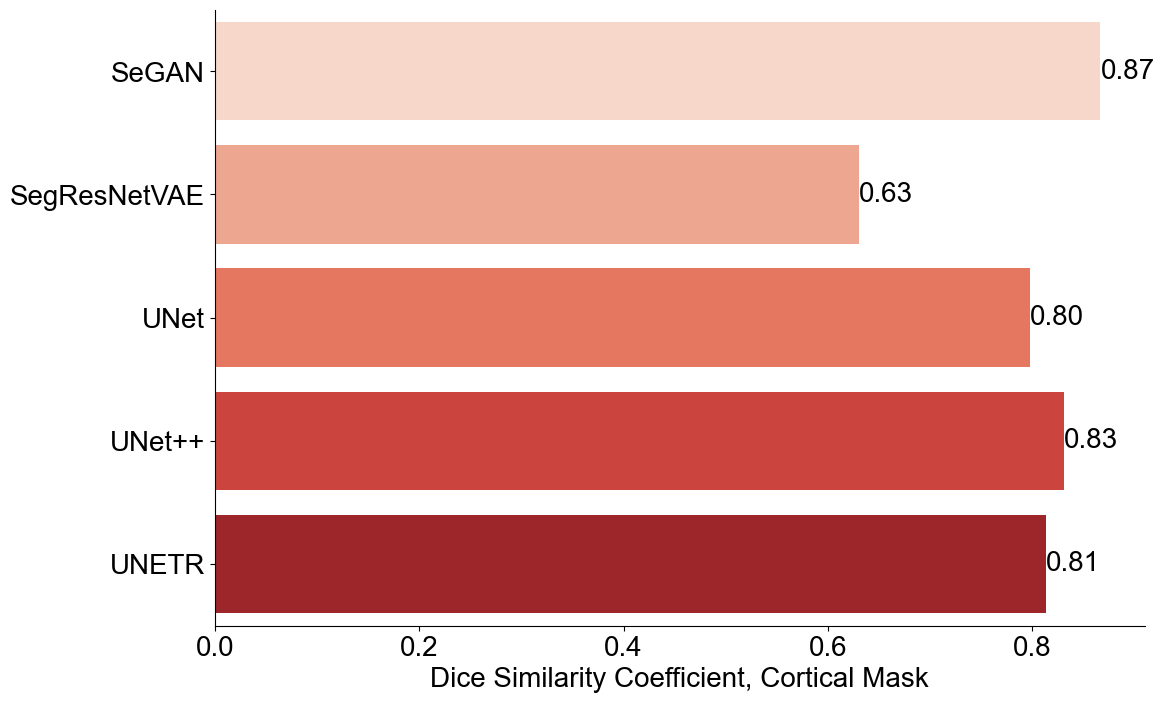

In [5]:
rc = {'figure.figsize':(10,5),
      'axes.facecolor':'white',
      'axes.grid' : True,
      'grid.color': '1',
      'font.family':'Arial',
      'font.size' : 20}
plt.rcParams.update(rc)


plt.figure(figsize=(12,8))

ax = sns.barplot(data=df, y="label", x="cort DSC", palette="Reds")
# plt.legend(loc="lower left")

ax.set(
    ylabel="",
    xlabel="Dice Similarity Coefficient, Cortical Mask"
)

for i in ax.containers:
    ax.bar_label(i, fmt="%0.2f")

plt.grid(axis="x")
sns.despine()

plt.show()

Let's instantiate a SeGAN and load the checkpoint of the best model to see qualitatively how it's doing...

In [6]:
ref_model_dir = path.join("..", "from_arc", "segan_3d_knee_base_cv", "21100349_f0")
ref_hparams_fn = path.join(ref_model_dir, "hparams.yaml")

with open(ref_hparams_fn) as f:
    ref_hparams = yaml.safe_load(f)

# create the model
model_kwargs = {
    'input_channels': ref_hparams["input_channels"],
    'output_classes': ref_hparams["output_channels"],
    'num_filters': ref_hparams["model_channels"],
    'channels_per_group': ref_hparams["channels_per_group"],
    'upsample_mode': ref_hparams["upsample_mode"],
    'is_3d': ref_hparams["is_3d"]
}
segmentor, discriminators = get_segmentor_and_discriminators(**model_kwargs)
segmentor.float()
for d in discriminators:
    d.float()

checkpoint_path = glob(path.join(ref_model_dir, "checkpoints", "*.ckpt"))[0]
print(f"Loading model and task from: {checkpoint_path}")

Loading model and task from: ../from_arc/segan_3d_knee_base_cv/21100349_f0/checkpoints/epoch=49-step=1300.ckpt


In [7]:
task = SeGANTask.load_from_checkpoint(
    checkpoint_path,
    segmentor=segmentor,
    discriminators=discriminators,
    loss_function=L1Loss(),
    learning_rate=ref_hparams["learning_rate"],
    map_location=torch.device("cpu")
)

In [1]:
task

NameError: name 'task' is not defined